In [8]:
from fastai.data.all import *; from loading import *
import librosa

ImportError: attempted relative import with no known parent package

In [3]:
class TTSDataset(torch.utils.data.Dataset):
    def __init__(self, path_data, path_vocab, sample_rate=22050, 
                 n_fft=2048, hop_length=512, n_bins=80, ratio=1,
                 preload=False):
        self.current_idx = 0
        self.preload = preload
        self.files = get_audio_files(path_data)
        self.files = self.files[:int(ratio * len(self.files))]
        self.files_tg = self.files.map(lambda x: x.with_suffix('.TextGrid'))
        
        self.vocab = L(path_vocab.open().readlines()).map(lambda x: x.strip())
        self.vocab = self.vocab + L(["<pad>", "spn"])
        self.pho2idx = {phoneme: i for i, phoneme in enumerate(self.vocab)}
        self.pad_num = self.pho2idx["<pad>"]
        
        
        self.load_audio = partial(librosa.load, sr=sample_rate)
        self.melspectrogram = partial(librosa.feature.melspectrogram, n_fft=n_fft, 
                                      hop_length=hop_length, n_mels=n_bins)
        self.get_phoneme_duration = partial(get_phoneme_duration, sr=sample_rate, 
                                            hop_length=hop_length)
    
        if preload:
            self.wavs = self.files.map(self.load_audio).map(lambda x: x[0])

            self.phones, self.durations = zip(*self.files_tg.map(get_tiers).map(
                                              self.get_phoneme_duration))
    
    def __iter__(self): return self

    def __next__(self):
        if self.current_idx < self.__len__():
            tmp = self.__getitem__(self.current_idx)
            self.current_idx += 1
            return tmp
        else:
            raise StopIteration
        
    def __len__(self): return len(self.files)
    
    def __getitem__(self, idx):
        if self.preload:
            wav = self.wavs[idx]
            phones, durations = self.phones[idx], self.durations[idx]                
        else:
            wav = self.load_audio(self.files[idx])[0]
            tiers = get_tiers(self.files_tg[idx])
            phones, durations = self.get_phoneme_duration(tiers)
        
        
        mel = tensor(self.melspectrogram(y=wav))[...,:sum(durations)]
        nums = tensor(L(phones).map(self.pho2idx))
        durations = tensor(durations)
        
        
        return mel, nums, durations

In [ ]:
path_ds = Path("../data/LJSpeech-1.1/")
path_vocab = Path("../data/CMUDict/cmudict-0.7b.symbols.txt")

In [ ]:
ds = TTSDataset(path_ds, path_vocab)

In [ ]:
mels, phones, durations = ds[0]

In [ ]:
def show_mel(mels): plt.imshow(librosa.power_to_db(mels), origin='lower');

In [ ]:
clipped = mels[:,:sum(durations)]
mels.shape, clipped.shape

In [ ]:
show_mel(clipped)

In [ ]:
from padding import *

In [ ]:
def show_mels(mels):
    num_mels = len(mels)
    fig, axes = plt.subplots(nrows=num_mels, ncols=1, figsize=(10, 2*num_mels))
    for i, mel in enumerate(mels):
        im = axes[i].imshow(librosa.power_to_db(mel), origin='lower')
        axes[i].set(title=f'Melspectrogram {i}')
    plt.tight_layout()
    plt.show(True)

In [ ]:
mels, phones, durations = zip(*[ds[i] for i in range(4)])

In [ ]:
show_mels(mels)

In [ ]:
mel_padded = pad_mels(mels); mel_padded.shape

In [ ]:
show_mels(mel_padded)

In [15]:
pad_phones(phones, ds.pad_num)

tensor([[69, 77, 55, 22, 69, 67, 24, 44, 40, 14, 66, 27,  9, 68, 77, 69, 44, 56,
         42, 49, 67, 14, 52, 80, 59, 69, 69, 77, 54, 30, 55, 33, 18, 55, 26, 27,
          9, 42, 18, 67, 65, 49, 52, 44, 56, 44, 55, 80, 45, 55, 26, 58, 82, 30,
         55, 26, 52, 80, 59, 69, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84],
        [27,  6, 69, 67, 38, 54, 81, 45, 66, 80, 30, 55, 26, 33, 22,  9, 67, 85,
         52, 38, 54, 69, 77, 27,  9, 65, 34, 83,  9, 55, 70, 66, 59, 55, 27,  9,
         24,  7, 24,  9, 53, 59, 55, 48,  9, 55, 82, 59, 65,  9, 55, 53, 48, 66,
         44, 24, 30, 53, 26, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84,
         84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84],
        [27,  9, 40,  6, 52, 69, 80,  2, 82, 80, 38, 52, 40, 50, 53, 26, 80, 30,
 

In [16]:
pad_durations(durations)

tensor([[ 3,  4,  3,  6,  3,  3,  3,  2,  5,  3,  3,  2,  1,  9,  4,  2,  4,  7,
          8,  3,  7,  6,  7,  2,  5,  9, 14,  4,  4,  6,  6,  7,  5,  2,  1,  0,
          4,  0, 10,  7,  6,  3,  3,  3,  3,  3,  3,  2,  3,  3,  2,  9,  9, 11,
          2,  3,  3,  2,  5, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  5,  3,  4,  7,  3,  3,  5,  7,  3,  2,  3,  2,  7,  5,  4,  3, 37,
          4,  6,  2,  3,  1,  1,  1,  4,  5,  2,  2,  3,  3,  3,  9,  6, 22,  1,
          2,  3,  2,  0,  3,  4,  1,  3,  1,  1,  3,  7,  3,  2,  2,  2,  2,  4,
          1,  5,  6,  7,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  5,  5,  3,  4,  3,  9,  4,  3,  3,  3,  4,  3,  3,  3,  1,  3,
 

In [37]:
def clip_mel(mel, duration): return mel[:,:sum(duration)]

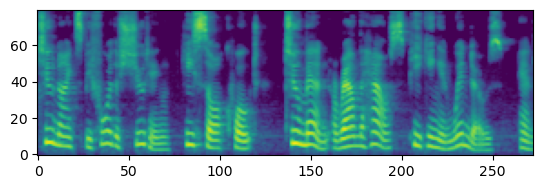

In [40]:
show_mel(clip_mel(mels[0], durations[0]))